# Exploratory Data Analysis (EDA)

## 1. Data Loading

### 1.1 Import Libraries
Essential libraries for data manipulation and visualization.

In [32]:
# Standard Library
import os
import sys
import random  # Used for random sampling of images or tomograms

# Add project root to system path (for relative imports to work)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Core Data Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Project Configuration
from src import config

In [33]:
print(config.PROJECT_ROOT)

/Users/ramy/Desktop/team_project/BYU_Locating_Bacterial_Flagellar_Motors_2025


In [34]:
print(config.TRAIN_LABELS_PATH)

/Users/ramy/Desktop/team_project/BYU_Locating_Bacterial_Flagellar_Motors_2025/data/raw/train_labels.csv


### 1.2 Load Labels CSV
Read the training labels from the appropriate path using `pandas`.

In [35]:
# Load labels using the path defined in config.py
train_labels_path = config.TRAIN_LABELS_PATH

# Read the CSV file
labels = pd.read_csv(train_labels_path)

### 1.3 Preview Data
We display basic information about the dataset including:
- Number of unique tomograms.
- The shape of the DataFrame.
- A preview of the first few rows.

In [36]:
# Check number of unique tomograms
num_tomograms = labels['tomo_id'].nunique()
print(f"Number of unique tomograms in the training set: {num_tomograms}")

# Show shape and first few rows
print(f"Dataset contains {labels.shape[0]} rows and {labels.shape[1]} columns.")
labels.head()

Number of unique tomograms in the training set: 648
Dataset contains 737 rows and 10 columns.


,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,0,tomo_003acc,-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1
2,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
3,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
4,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6


## 2. Missing Values and Data Types
Understanding the completeness and structure of the data is essential before modeling. This section examines:
- Missing values across columns
- Data types of each feature

### 2.1 Check for Missing Values
We inspect each column to see if there are any missing (`NaN`) values that may require imputation or special handling.

In [37]:
# Check for missing values in each column
missing_values = labels.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 row_id                  0
tomo_id                 0
Motor axis 0            0
Motor axis 1            0
Motor axis 2            0
Array shape (axis 0)    0
Array shape (axis 1)    0
Array shape (axis 2)    0
Voxel spacing           0
Number of motors        0
dtype: int64


### 2.2 Examine Data Types
We check the data types of each column to ensure they match our expectations (e.g., numerical vs. categorical).

In [38]:
# Display data types of all columns
data_types = labels.dtypes
print("Data types:\n", data_types)

Data types:
 row_id                    int64
tomo_id                  object
Motor axis 0            float64
Motor axis 1            float64
Motor axis 2            float64
Array shape (axis 0)      int64
Array shape (axis 1)      int64
Array shape (axis 2)      int64
Voxel spacing           float64
Number of motors          int64
dtype: object


### 2.3 Column Descriptions

- **`row_id`** — Index of the row (unique per motor record).  
- **`tomo_id`** — Unique identifier for each tomogram. One tomogram may have multiple motors, so it can appear in multiple rows.  
- **`Motor axis 0`** — Z-coordinate of the motor (i.e., which 2D slice it is located in).  
- **`Motor axis 1`** — Y-coordinate of the motor (vertical position in the slice).  
- **`Motor axis 2`** — X-coordinate of the motor (horizontal position in the slice).  
- **`Array shape axis 0`** — Number of slices in the tomogram (Z-axis length).  
- **`Array shape axis 1`** — Height of each 2D slice (Y-axis length).  
- **`Array shape axis 2`** — Width of each 2D slice (X-axis length).  
- **`Voxel spacing`** — Physical spacing in angstroms per voxel (scaling factor).  
- **`Number of motors`** — Total number of motors in the tomogram.  
  > Note: Each row represents one motor. So tomograms with multiple motors appear multiple times.

## 3. Target Distribution (Number of Motors)
This section explores the distribution of the target variable — the number of motors in each tomogram.
Understanding class balance is important for model training and evaluation.

### 3.1 Frequency of Motor Counts
We begin by examining how frequently each motor count appears in the dataset.

In [39]:
# Count the frequency of each motor count
motor_counts = labels["Number of motors"].value_counts().sort_index()
print("Frequency of motor counts:\n", motor_counts)

Frequency of motor counts:
 Number of motors
0     286
1     313
2      56
3      18
4      36
6      18
10     10
Name: count, dtype: int64


### 3.2 Visualize the Distribution
We plot the distribution of the target variable using a bar chart to better understand class balance.

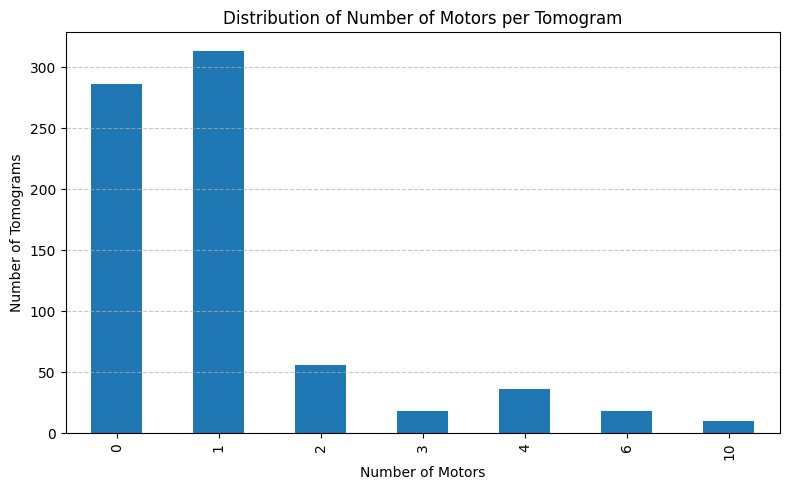

In [40]:
import matplotlib.pyplot as plt

# Plot the distribution
plt.figure(figsize=(8, 5))
motor_counts.plot(kind='bar')
plt.title("Distribution of Number of Motors per Tomogram")
plt.xlabel("Number of Motors")
plt.ylabel("Number of Tomograms")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.3 Box Plot of Motor Axis 0 by Number of Motors

This plot explores how the Z-axis coordinate of motors (`Motor axis 0`) varies across tomograms with different numbers of motors.
It helps reveal any spatial patterns, outliers, or labeling conventions in motor placement relative to tomogram depth.

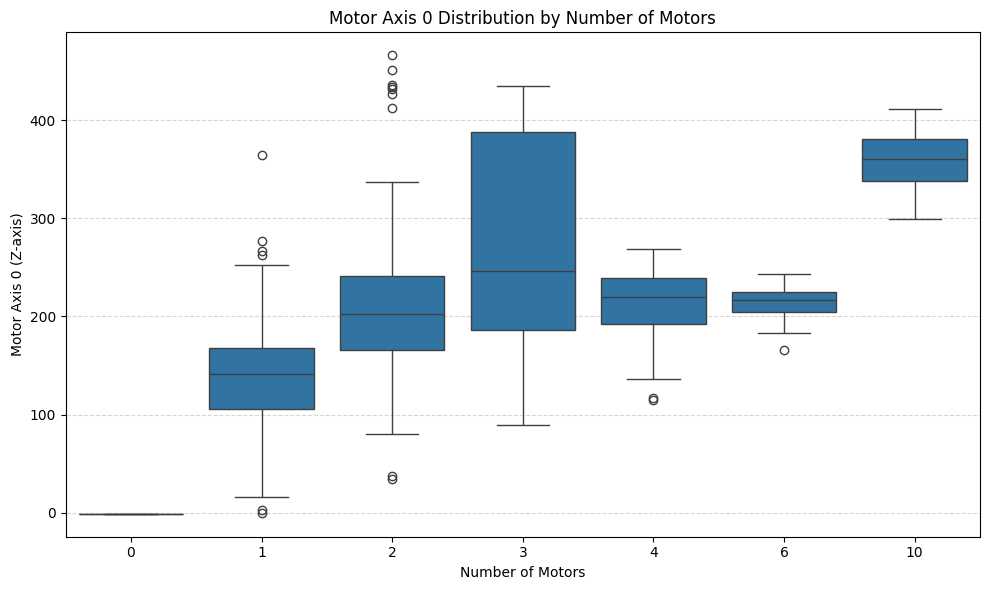

In [41]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Number of motors', y='Motor axis 0', data=labels)
plt.title("Motor Axis 0 Distribution by Number of Motors")
plt.xlabel("Number of Motors")
plt.ylabel("Motor Axis 0 (Z-axis)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The boxplot reveals the following:

- Tomograms labeled with `0` motors have Z-values near 0 or -1, confirming placeholder values used to indicate absence of motors.
- Tomograms with 1 to 4 motors show increasing variability in Z-coordinates, especially with 3 motors having the widest spread.
- Tomograms with 10 motors have more concentrated Z-coordinates in higher depth slices, hinting at possible structural or acquisition-related regularities.
- The presence of outliers across all classes suggests non-uniform spatial distribution and potentially noisy annotations.

## 4. Tomogram Shape & Voxel Spacing

In this section, we analyze the structural dimensions of each tomogram and the voxel spacing used to capture them. 
Understanding the variation in shape and scale is critical for preprocessing, normalization, and model input design.

We examine:
- The distribution of tomogram dimensions across the three axes (Z, Y, X).
- The voxel spacing (in angstroms per voxel), which determines the physical scale of the volumes.

### 4.1 Distribution of Tomogram Shapes

Each tomogram in the dataset is a 3D volume composed of multiple 2D image slices. 
This section examines the distributions of the array shape along each axis (`z`, `y`, `x`) 
to understand the size variability across samples.

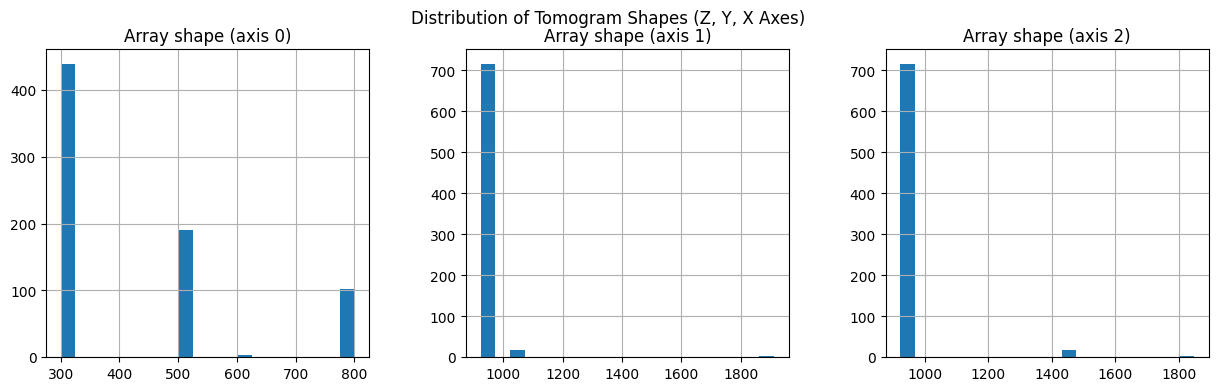

In [42]:
# Plot histograms for each axis dimension
shape_cols = ['Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)']
labels[shape_cols].hist(bins=20, figsize=(15, 4), layout=(1, 3))
plt.suptitle("Distribution of Tomogram Shapes (Z, Y, X Axes)")
plt.show()

### 4.2 Voxel Spacing Distribution

Voxel spacing represents the real-world scale (in angstroms) of each voxel.

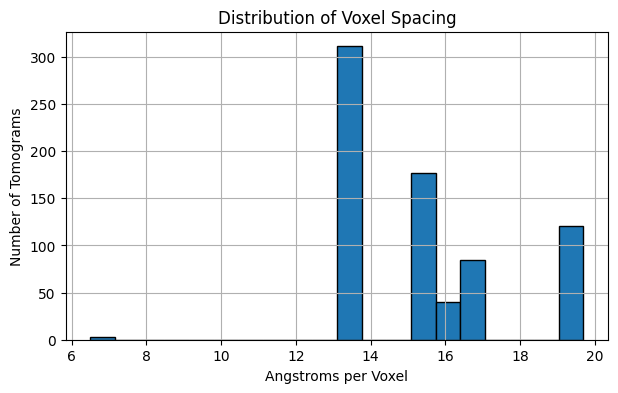

In [43]:
# Histogram of voxel spacing
plt.figure(figsize=(7, 4))
plt.hist(labels["Voxel spacing"], bins=20, edgecolor='black')
plt.title("Distribution of Voxel Spacing")
plt.xlabel("Angstroms per Voxel")
plt.ylabel("Number of Tomograms")
plt.grid(True)
plt.show()

### 4.3 Observations

**Tomogram Shape (Axes 0, 1, 2):**

- **Axis 0 (Z-axis / depth)** shows discrete modes centered around 300, 500, and 800 slices, indicating tomograms come in a few fixed depth configurations.
- **Axis 1 and 2 (Y and X axes / height and width)** are much more consistent, with most tomograms around 960–1000 pixels in both dimensions. A small number extend beyond 1400 and 1800, likely outliers or different imaging settings.

**Voxel Spacing:**

- Voxel spacing is **not uniform**. While the majority of tomograms have spacings near **13–16 Å per voxel**, a few samples go as low as **6.5 Å** or as high as **19.7 Å**.
- This variability suggests tomograms were acquired using different microscope settings or resolutions.

**Implications:**

- Coordinate values (`Motor axis 0/1/2`) must be **normalized by tomogram shape** to ensure comparability across samples.
- In some models (especially those considering spatial accuracy), voxel spacing should be factored in — either to scale coordinates into physical units or as an input feature.
- Tomograms with unusual shapes or voxel spacings may require special handling or exclusion, especially if their frequency is low.

## 5. Visual Inspection of Example Tomograms

Before training models, it's essential to visually understand the structure of the tomograms and how motors appear within them. 
In this section, we:
- Load a sample tomogram (as 2D slices)
- Display selected slices
- Overlay the motor location to verify annotation alignment

### 5.1 Load and Display Slices

Tomograms are stored as folders of 2D `.jpg` slices, ordered by their Z-index (`slice_0000.jpg`, `slice_0001.jpg`, ...). 
We load a sample tomogram and visualize its middle slices.

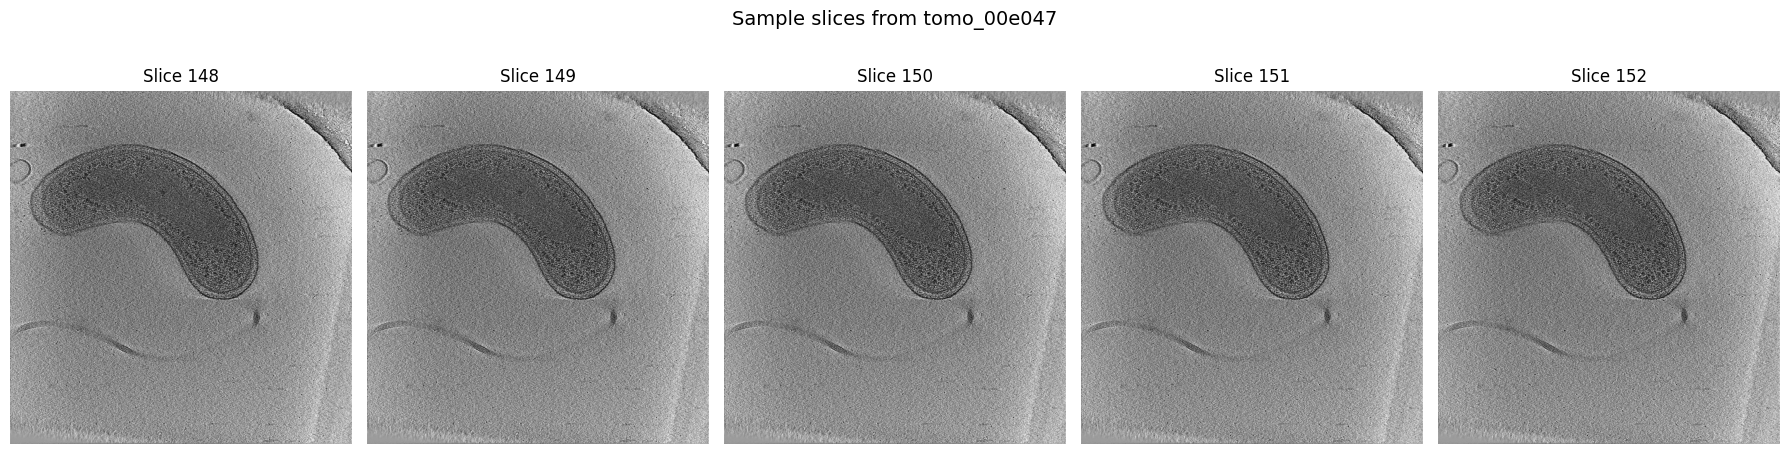

In [44]:
# Choose a sample tomo_id known to contain a motor
sample_tomo_id = 'tomo_00e047'  # replace if needed
sample_dir = os.path.join(config.FULL_DATA_TRAIN_DIR, sample_tomo_id)

# Load sorted list of slice filenames
slices = sorted([f for f in os.listdir(sample_dir) if f.endswith('.jpg')])
num_slices = len(slices)

# Display 5 mid-range slices
mid_idx = num_slices // 2
selected_indices = [mid_idx - 2, mid_idx - 1, mid_idx, mid_idx + 1, mid_idx + 2]

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for ax, idx in zip(axes, selected_indices):
    img_path = os.path.join(sample_dir, slices[idx])
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

plt.suptitle(f"Sample slices from {sample_tomo_id}", fontsize=14)
plt.tight_layout()
plt.show()

### 5.2 Overlay Motor Coordinates on a Slice

We now highlight the motor position on the slice corresponding to its `Motor axis 0` value to visually confirm annotation accuracy.

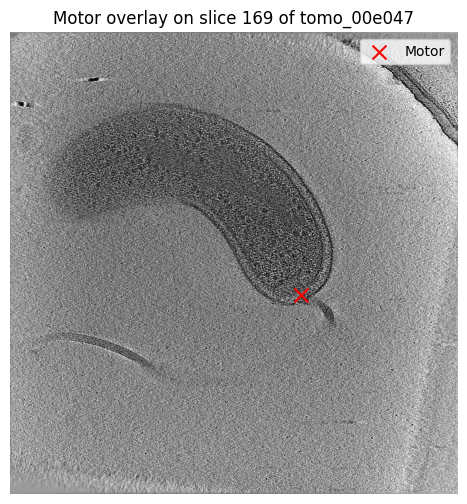

In [45]:
# Get motor location for the sample tomo
motor_row = labels[labels['tomo_id'] == sample_tomo_id].iloc[0]
z, y, x = int(motor_row['Motor axis 0']), motor_row['Motor axis 1'], motor_row['Motor axis 2']

# Load the image slice containing the motor
motor_slice = Image.open(os.path.join(sample_dir, f"slice_{z:04d}.jpg"))

# Plot with overlay
plt.figure(figsize=(6, 6))
plt.imshow(motor_slice, cmap='gray')
plt.scatter([x], [y], color='red', marker='x', s=100, label='Motor')
plt.title(f"Motor overlay on slice {z} of {sample_tomo_id}")
plt.legend()
plt.axis('off')
plt.show()

## 6. Image Dimensions for YOLO Preparation

### 6.1 Extract JPEG Image Dimensions

We iterate over each tomogram directory and extract the dimensions of one representative JPEG slice per tomogram. This helps verify whether all images have consistent dimensions, which is essential for configuring YOLO-based models that require fixed input sizes.

In [46]:
# Path to external sampled train directory (not tracked by Git)
sampled_train_dir = config.EXTERNAL_SAMPLED_TRAIN_DIR

# Gather image dimensions from one sample image per tomogram
dimensions = []

for tomo_folder in os.listdir(sampled_train_dir):
    tomo_path = os.path.join(sampled_train_dir, tomo_folder)
    if os.path.isdir(tomo_path):
        for img_file in os.listdir(tomo_path):
            if img_file.endswith(".jpg"):
                img_path = os.path.join(tomo_path, img_file)
                with Image.open(img_path) as img:
                    width, height = img.size
                    dimensions.append((width, height))
                break  # Only one sample per tomogram
df_dims = pd.DataFrame(dimensions, columns=["width", "height"])
df_dims.head()

,width,height
0,956,924
1,928,960
2,928,960
3,960,928
4,928,959


### 6.2 Analyze Unique Image Dimensions

Now that we’ve gathered the width and height of representative JPEG slices, we’ll analyze the frequency of each unique dimension. This helps us understand the variety in image sizes and determine how much resizing or padding may be needed before training detection models.

In [47]:
# Count unique (width, height) pairs
dimension_counts = df_dims.value_counts().reset_index(name="count")
dimension_counts.columns = ["width", "height", "count"]

# Display sorted frequency
dimension_counts.sort_values(by="count", ascending=False).reset_index(drop=True)

,width,height,count
0,928,960,25
1,960,928,7
2,928,928,6
3,928,959,5
4,956,924,3
5,1440,1024,3
6,959,927,1


**Observation**

The dataset contains images with **multiple unique resolutions**, with the most common dimensions being `(928, 960)` and `(960, 928)`, indicating near-square shapes but with differing orientations. A few other resolutions like `(1440, 1024)` and `(928, 928)` also appear, suggesting **inconsistencies in image dimensions** across tomograms. These variations must be **handled explicitly** during data preprocessing to ensure compatibility with models like YOLO, which require consistent input sizes.

### 6.3 Visualize Image Dimension Frequencies

To better understand the variety in image dimensions across the dataset, we visualize the frequency of each unique `(width, height)` pair using a bar chart. This helps to identify dominant image shapes and guides the choice of resizing strategies for downstream models like YOLO.

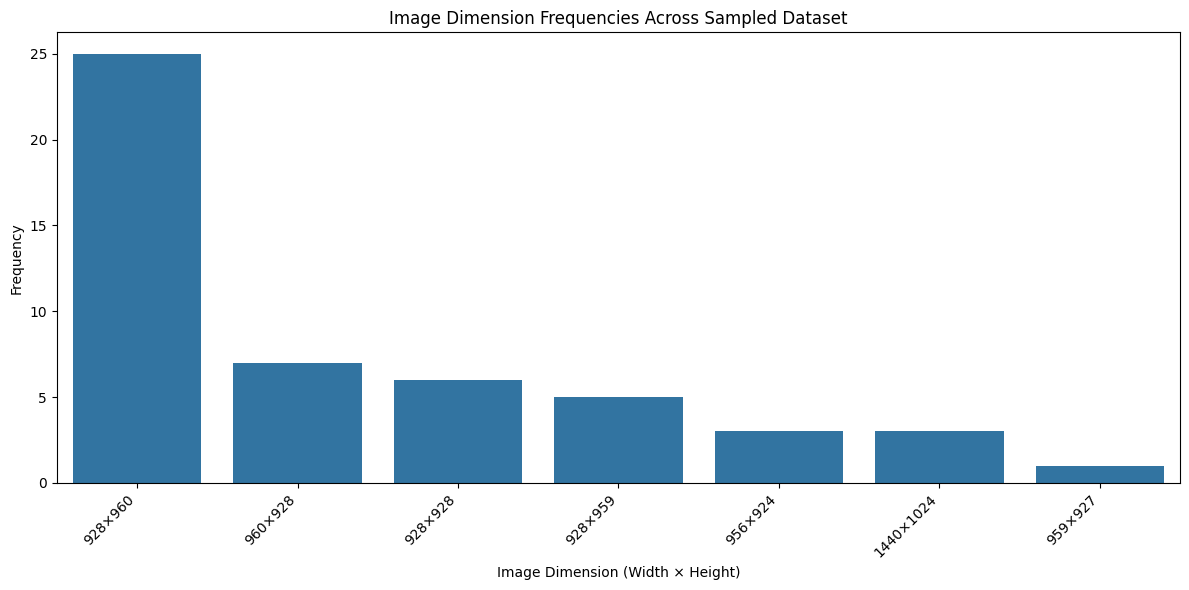

In [48]:
# Combine width and height into a string label for plotting
dimension_counts["dimension"] = dimension_counts.apply(lambda row: f"{row['width']}×{row['height']}", axis=1)

# Plot the dimension frequencies
plt.figure(figsize=(12, 6))
sns.barplot(data=dimension_counts.sort_values(by="count", ascending=False), 
            x="dimension", y="count")

plt.xticks(rotation=45, ha='right')
plt.title("Image Dimension Frequencies Across Sampled Dataset")
plt.xlabel("Image Dimension (Width × Height)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### 7.1 Distribution of Voxel Spacing

Voxel spacing represents the physical resolution of tomograms. Variability in spacing implies that similar voxel distances may correspond to different physical lengths, which can impact detection accuracy. We'll plot the distribution to understand its range and variance.

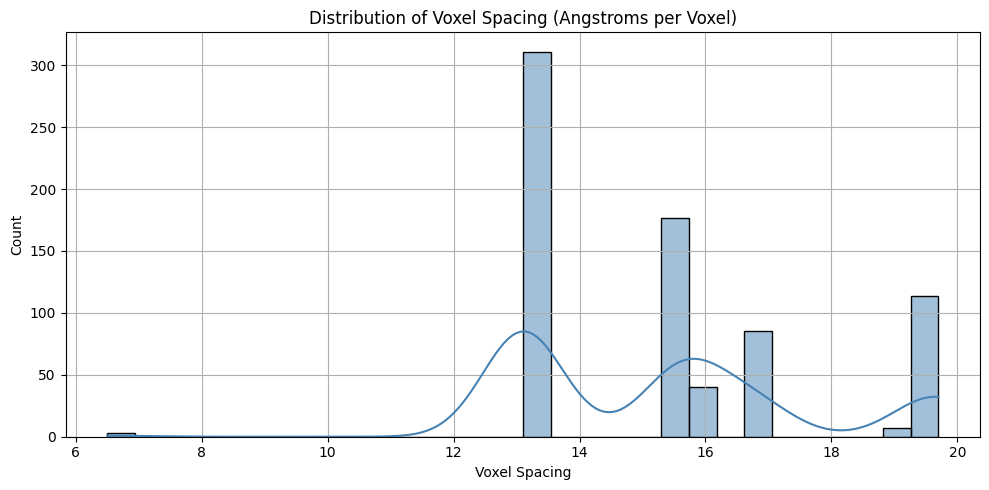

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(labels["Voxel spacing"], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Voxel Spacing (Angstroms per Voxel)")
plt.xlabel("Voxel Spacing")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### 7.2 Summary Statistics of Voxel Spacing

This provides the basic statistical overview (min, max, mean, etc.) to inform normalization strategies or decide if rescaling is necessary.

In [50]:
voxel_stats = labels["Voxel spacing"].describe()
print(voxel_stats)

count    737.000000
mean      15.341655
std        2.398197
min        6.500000
25%       13.100000
50%       15.600000
75%       16.800000
max       19.700000
Name: Voxel spacing, dtype: float64


### 7.3 Observations

- Voxel spacing is concentrated around a few common values (13.1, 15.6, 16.8), indicating standard acquisition settings.
- The range spans from 6.5 to 19.7 Å/voxel with a mean of ~15.3 and moderate variance.

## 8. Class Imbalance & Tomogram Coverage

While section 3 examined the **distribution of motor counts as labels** (i.e., how many tomograms have 0, 1, or more motors), this section focuses on the **actual grouping of motors per tomogram ID** and their **spatial positioning along the z-axis**.

This helps confirm whether each tomogram is labeled correctly and whether motors are clustered in specific spatial regions — both of which influence model learning and sampling strategies.

### 8.1 Motors per Tomogram Distribution

Here we count how many motors are recorded in each tomogram (i.e., how many rows share the same `tomo_id`). This helps us cross-validate the label structure and identify tomograms with dense motor presence.

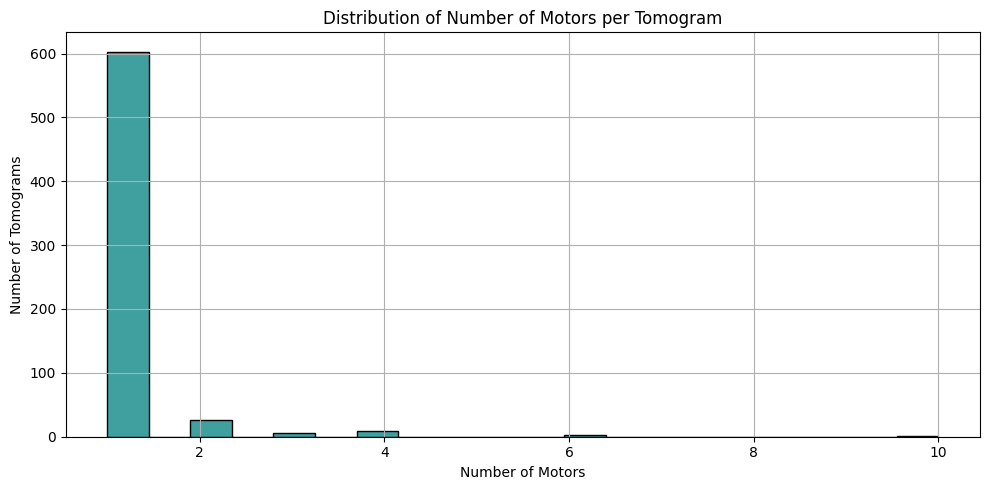

In [51]:
motors_per_tomo = labels.groupby("tomo_id").size()

plt.figure(figsize=(10, 5))
sns.histplot(motors_per_tomo, bins=20, color="teal", edgecolor="black")
plt.title("Distribution of Number of Motors per Tomogram")
plt.xlabel("Number of Motors")
plt.ylabel("Number of Tomograms")
plt.grid(True)
plt.tight_layout()
plt.show()

Most tomograms have only 1 or 0 motors, with very few having more than 2. This confirms a strong class imbalance.

### 8.2 Z-Axis Coverage per Tomogram

We normalize the Z-axis location (`Motor axis 0`) by the tomogram’s depth (`Array shape axis 0`) to analyze whether motors are uniformly distributed across the volume or tend to appear in certain regions.

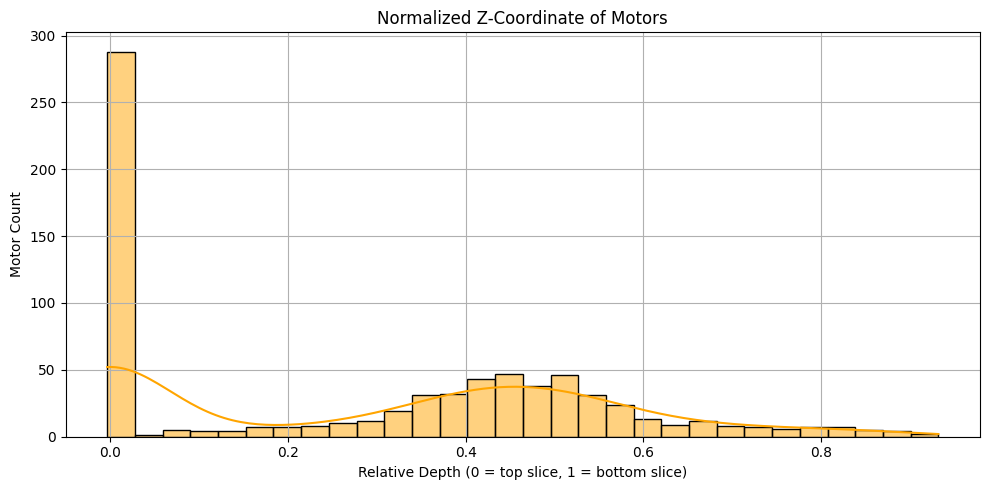

In [52]:
labels["z_norm"] = labels["Motor axis 0"] / labels["Array shape (axis 0)"]

plt.figure(figsize=(10, 5))
sns.histplot(labels["z_norm"].dropna(), bins=30, color="orange", kde=True)
plt.title("Normalized Z-Coordinate of Motors")
plt.xlabel("Relative Depth (0 = top slice, 1 = bottom slice)")
plt.ylabel("Motor Count")
plt.grid(True)
plt.tight_layout()
plt.show()

The spike near Z = 0 is an artifact caused by placeholder coordinates (`-1`) in tomograms with no motors. Genuine motor locations appear more uniformly distributed across tomogram depth.

### 9.1 Visual Inspection of Sample Slices

We visually inspect randomly sampled tomogram slices to get a sense of brightness, contrast, and noise levels in the data.

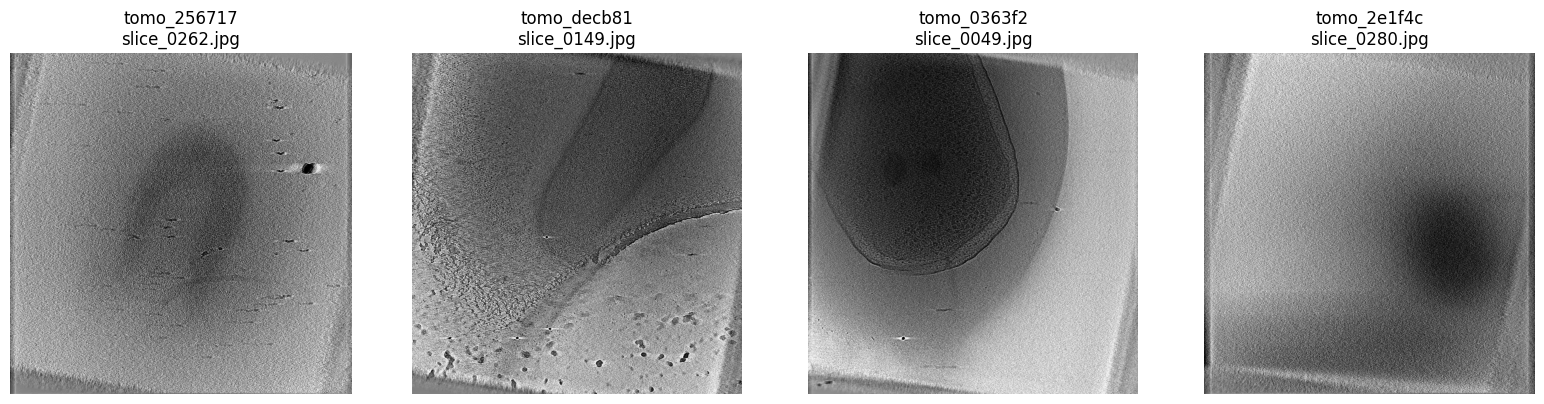

In [53]:
# Pick a few random tomograms
sampled_tomos = random.sample(os.listdir(config.EXTERNAL_SAMPLED_TRAIN_DIR), 4)

# Display a random slice from each
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for ax, tomo_id in zip(axs, sampled_tomos):
    tomo_path = os.path.join(config.EXTERNAL_SAMPLED_TRAIN_DIR, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_path) if f.endswith(".jpg")])
    slice_path = os.path.join(tomo_path, random.choice(slice_files))
    
    img = Image.open(slice_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{tomo_id}\n{os.path.basename(slice_path)}")
    ax.axis("off")

plt.tight_layout()
plt.show()

The example slices show varied brightness and contrast, with some appearing smooth and others containing strong shadows or structural noise. Overall, contrast is low and would benefit from normalization.

### 9.2 Histogram of Pixel Intensities

We compute pixel intensity distributions to quantify brightness and contrast variability across tomograms.

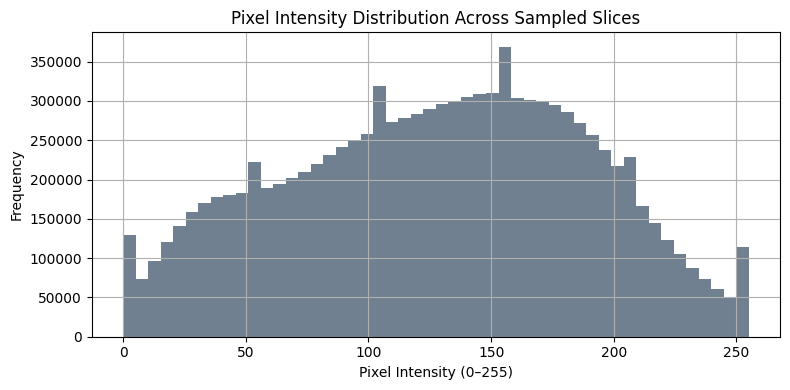

In [54]:
# Load and flatten a few slices
pixel_values = []

for tomo_id in sampled_tomos:
    tomo_path = os.path.join(config.EXTERNAL_SAMPLED_TRAIN_DIR, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_path) if f.endswith(".jpg")])
    
    for img_name in slice_files[:3]:  # check a few slices per tomo
        img_path = os.path.join(tomo_path, img_name)
        img = Image.open(img_path).convert('L')  # grayscale
        pixel_values.extend(np.array(img).flatten())

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(pixel_values, bins=50, color='slategray')
plt.title("Pixel Intensity Distribution Across Sampled Slices")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Pixel values are fairly symmetrically distributed around the midtones (100–150), but with spikes at both low and high ends, possibly from imaging artifacts or compression. This confirms the need for pixel intensity normalization before model input.

## 10. Summary of Preprocessing Needs

The table below summarizes key preprocessing recommendations based on the findings throughout the EDA.

| Issue                                  | Insight from EDA                                   | Recommended Action                              |
|---------------------------------------|----------------------------------------------------|--------------------------------------------------|
| Missing motors / placeholder values   | Motors with `-1` coordinates → Z ≈ 0               | Filter or handle separately in training          |
| Voxel spacing variability             | Multiple voxel sizes (6.5–19.7 Å)                  | Normalize spacing if needed (esp. for 3D models) |
| Class imbalance                       | Most tomograms have 0–1 motor                      | Use class weighting or balanced sampling         |
| Spatial distribution (Z-axis)         | Motors tend to appear mid-volume or vary           | Consider positional augmentation                 |
| Image dimensions mismatch             | Multiple shapes (e.g., 928×960, 1440×1024)         | Resize or pad images to a common shape           |
| Low image contrast                    | Histogram shows narrow pixel range                 | Normalize intensity, apply contrast enhancement  |
| Noise in cryo-ET slices               | Visual and intensity noise                         | Optional denoising (e.g., Gaussian, median)      |